**Optional: install `graphviz`**

To produce the decision tree visualization you should install the graphviz package into your system: 

https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft




In [1]:
# !pip install graphviz

In [2]:
# Run one of these in case you have problems with graphviz

# All users: try this first
# ! conda install graphviz

# If that doesn't work:
# Ubuntu/Debian users only
# ! sudo apt-get update && sudo apt-get install graphviz

# Mac users only (assuming you have homebrew installed)
# ! brew install graphviz

# Windows users, check the stack overflow link. Sorry!

In [3]:
from collections import Counter
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.base import clone
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split

sns.set()

In [4]:
# Uncomment this if you have graphviz installed
# import graphviz


## Import preprocessed data

In [5]:
df = pd.read_csv(join('..', 'data', 'data_preprocessed.csv'))

In [6]:
df.head()

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,...,oh_status_Widow,oh_gender_M,oh_dependents_1.0,oh_description_Kind of OK,oh_description_Meh...,oh_description_OK nice!,oh_description_Take my money!!,PC0,PC1,PC2
0,78,0.743162,1.191605,0.457819,1402,-0.617023,-0.243065,1.216847,0.495837,-0.499274,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.896356,-1.937697,1.120781
1,88,1.559488,1.100011,-1.535723,1537,0.166160,-0.790228,0.740464,-0.374374,-0.631907,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.981092,-1.421498,0.785625
2,34,-1.548542,-0.823463,0.557496,44,-0.834573,1.672006,-0.371096,-0.809480,2.286023,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,-2.813108,0.381440,-0.780867
3,69,0.845528,0.550447,-1.402820,888,0.383710,0.440889,-0.768082,-0.084304,-0.234007,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.247013,-0.514177,-1.302203
4,69,0.782435,1.008417,-0.871209,1138,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.781920,-0.704805,-0.443376


In [7]:
df.columns

Index(['age', 'income', 'frq', 'rcn', 'mnt', 'clothes', 'kitchen',
       'small_appliances', 'toys', 'house_keeping', 'dependents',
       'per_net_purchase', 'gender', 'education', 'status', 'description',
       'birth_year', 'spent_online', 'oh_education_2nd Cycle',
       'oh_education_Graduation', 'oh_education_Master', 'oh_education_PhD',
       'oh_status_Married', 'oh_status_Single', 'oh_status_Together',
       'oh_status_Widow', 'oh_gender_M', 'oh_dependents_1.0',
       'oh_description_Kind of OK', 'oh_description_Meh...',
       'oh_description_OK nice!', 'oh_description_Take my money!!', 'PC0',
       'PC1', 'PC2'],
      dtype='object')

In [8]:
# Splitting feature names into groups
# Remember which metric_features we decided to keep?
metric_features = ['income',
 'frq',
 'rcn',
 'clothes',
 'kitchen',
 'small_appliances',
 'toys',
 'house_keeping',
 'per_net_purchase',
 'spent_online']

non_metric_features = df.columns[df.columns.str.startswith('oh_')].tolist() # CODE HERE
pc_features = df.columns[df.columns.str.startswith('PC')].tolist()  # CODE HERE

unused_features = [i for i in df.columns if i not in (metric_features+non_metric_features+pc_features) ]

In [9]:
print('metric_features:', metric_features)
print('\nnon_metric_features:', non_metric_features)
print('\nunused_features:', unused_features)
print('\npc_features:', pc_features)


metric_features: ['income', 'frq', 'rcn', 'clothes', 'kitchen', 'small_appliances', 'toys', 'house_keeping', 'per_net_purchase', 'spent_online']

non_metric_features: ['oh_education_2nd Cycle', 'oh_education_Graduation', 'oh_education_Master', 'oh_education_PhD', 'oh_status_Married', 'oh_status_Single', 'oh_status_Together', 'oh_status_Widow', 'oh_gender_M', 'oh_dependents_1.0', 'oh_description_Kind of OK', 'oh_description_Meh...', 'oh_description_OK nice!', 'oh_description_Take my money!!']

unused_features: ['age', 'mnt', 'dependents', 'gender', 'education', 'status', 'description', 'birth_year']

pc_features: ['PC0', 'PC1', 'PC2']


### Before we proceed

- Consider applying the outlier filtering method discussed last class.
    - We manually filtered the dataset's outliers based on a univariate analysis
- Consider dropping/transforming the variable "rcn". Why?
    - Very little correlation with any other variables
    - Remember the Component planes: the SOM's units were indistinguishable on this variable

In [10]:
# Based on the hyperparameters found in the previous class
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df[metric_features])
Counter(dbscan_labels)

Counter({0: 8715, -1: 102})

In [11]:
# Save the newly detected outliers (they will be classified later based on the final clusters)
df_out = df[dbscan_labels==-1].copy()

# New df without outliers and 'rcn'
df = df[dbscan_labels!=-1].copy()

<div class="alert alert-block alert-info" style="font-size:20px;">

- Ela guardou os outliers para pôr num cluster 

- Fazer listas de várias perspetivas

</div>

In [12]:
df_out.shape, df.shape

((102, 35), (8715, 35))

In [13]:
# Update features lists

metric_features.remove("rcn")
unused_features.append("rcn")

In [14]:
metric_features, unused_features

(['income',
  'frq',
  'clothes',
  'kitchen',
  'small_appliances',
  'toys',
  'house_keeping',
  'per_net_purchase',
  'spent_online'],
 ['age',
  'mnt',
  'dependents',
  'gender',
  'education',
  'status',
  'description',
  'birth_year',
  'rcn'])

# Clustering by Perspectives
- Demographic/Behavioral Perspective:
- Product Perspective:

In [15]:
# Split variables into perspectives (example, requires critical thinking and domain knowledge)
demographic_features = [
    'income',
    'frq',
    'per_net_purchase',
    'spent_online'
]

preference_features = [
    'clothes', 
    'kitchen', 
    'small_appliances',
    'toys', 
    'house_keeping', 
]

df_dem = df[demographic_features].copy()
df_prf = df[preference_features].copy()

## Testing on K-means and Hierarchical clustering
Based on (1) our previous tests and (2) the context of this problem, the optimal number of clusters is expected to be between 3 and 7.

In [16]:

# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    metric='euclidean'
)

In [17]:
# Functions from Lab 09

def get_ss(df, feats):
    """
    Calculate the sum of squares (SS) for the given DataFrame.

    The sum of squares is computed as the sum of the variances of each column
    multiplied by the number of non-NA/null observations minus one.

    Parameters:
    df (pandas.DataFrame): The input DataFrame for which the sum of squares is to be calculated.
    feats (list of str): A list of feature column names to be used in the calculation.

    Returns:
    float: The sum of squares of the DataFrame.
    """
    df_ = df[feats]
    ss = np.sum(df_.var() * (df_.count() - 1))
    
    return ss 


def get_ssb(df, feats, label_col):
    """
    Calculate the between-group sum of squares (SSB) for the given DataFrame.
    The between-group sum of squares is computed as the sum of the squared differences
    between the mean of each group and the overall mean, weighted by the number of observations
    in each group.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column in the DataFrame that contains the group labels.
    
    Returns
    float: The between-group sum of squares of the DataFrame.
    """
    
    ssb_i = 0
    for i in np.unique(df[label_col]):
        df_ = df.loc[:, feats]
        X_ = df_.values
        X_k = df_.loc[df[label_col] == i].values
        
        ssb_i += (X_k.shape[0] * (np.square(X_k.mean(axis=0) - X_.mean(axis=0))) )

    ssb = np.sum(ssb_i)
    

    return ssb


def get_ssw(df, feats, label_col):
    """
    Calculate the sum of squared within-cluster distances (SSW) for a given DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column containing cluster labels.

    Returns:
    float: The sum of squared within-cluster distances (SSW).
    """
    feats_label = feats+[label_col]

    df_k = df[feats_label].groupby(by=label_col).apply(lambda col: get_ss(col, feats), 
                                                       include_groups=False)

    return df_k.sum()



In [18]:
# Functions from Lab 09
 
def get_rsq(df, feats, label_col):
    """
    Calculate the R-squared value for a given DataFrame and features.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    feats (list): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column containing the labels or cluster assignments.

    Returns:
    float: The R-squared value, representing the proportion of variance explained by the clustering.
    """

    df_sst_ = get_ss(df, feats)                 # get total sum of squares
    df_ssw_ = get_ssw(df, feats, label_col)     # get ss within
    df_ssb_ = df_sst_ - df_ssw_                 # get ss between

    # r2 = ssb/sst 
    return (df_ssb_/df_sst_)
    

In [19]:
def get_r2_scores(df, feats, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        df_concat = pd.concat([df, 
                               pd.Series(labels, name='labels', index=df.index)], axis=1)  

        r2_clust[n] = get_rsq(df_concat, feats, 'labels' )
    return r2_clust



### Finding the optimal clusterer on demographic variables

In [20]:
df_dem[demographic_features]

,income,frq,per_net_purchase,spent_online
0,0.743162,1.191605,-1.257560,0.522055
1,1.559488,1.100011,-1.798649,-0.237578
2,-1.548542,-0.823463,0.906799,-0.904191
3,0.845528,0.550447,-0.391816,0.785568
4,0.782435,1.008417,-0.445925,1.237135
...,...,...,...,...
8812,0.618993,0.458853,0.257492,1.275517
8813,0.874744,0.733635,0.690363,1.865248
8814,-0.455617,-0.731869,1.556107,-0.801266
8815,-0.596155,0.825229,-0.608252,0.801051


In [21]:
# Obtaining the R² scores for each cluster solution on demographic variables
# This may take some time to run

r2_scores = {}

r2_scores['kmeans'] = get_r2_scores(df_dem, demographic_features, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_dem,                 # data
        demographic_features,   # features of perspective
        # use HClust, changing the linkage at each iteration
        hierarchical.set_params(linkage=linkage) 
    )


In [22]:
r2_scores_df = pd.DataFrame(r2_scores)
r2_scores_df

,kmeans,complete,average,single,ward
2,0.571844,0.095809,0.064693,0.001041,0.544738
3,0.679538,0.582479,0.582650,0.001704,0.655959
4,0.756802,0.671330,0.585952,0.002164,0.711623
5,0.789283,0.700576,0.586480,0.003354,0.758156
6,0.819704,0.748638,0.651671,0.004125,0.782667
7,0.839190,0.777335,0.743790,0.004540,0.805099
8,0.854611,0.796595,0.744352,0.004743,0.823297
9,0.866560,0.828341,0.782224,0.005648,0.838379


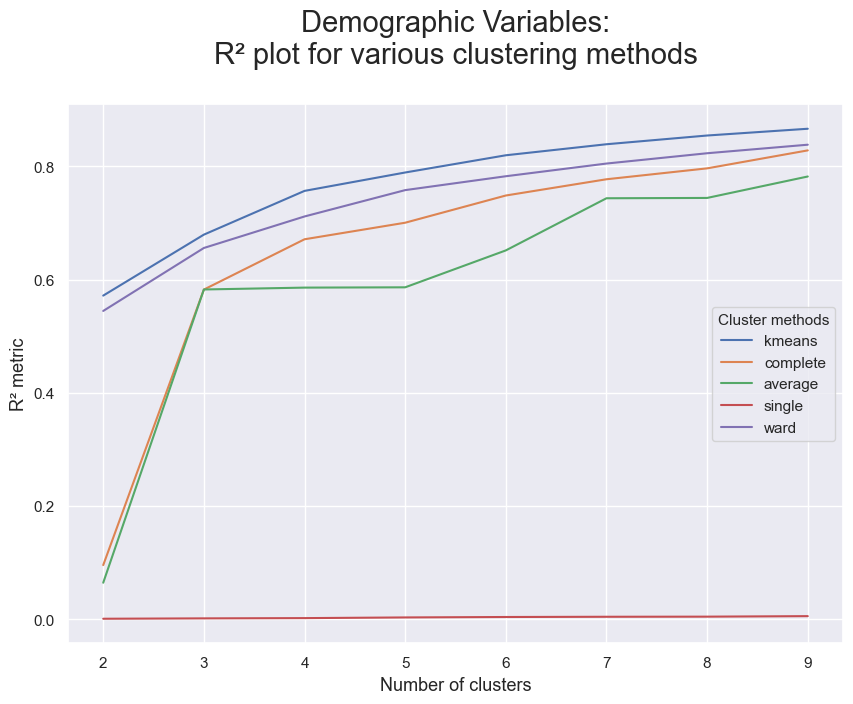

In [23]:
# Visualizing the R² scores for each cluster solution on demographic variables
r2_scores_df.plot.line(figsize=(10,7))

plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

<div class="alert alert-block alert-warning" style="font-size:20px;">

- **K-Means** tem maior $R^2$, *não podemos comparar $R^2$ de diferentes valores de clusters*
-  ver o **Elbow** 

</div>

### **Repeat the process for product variables**

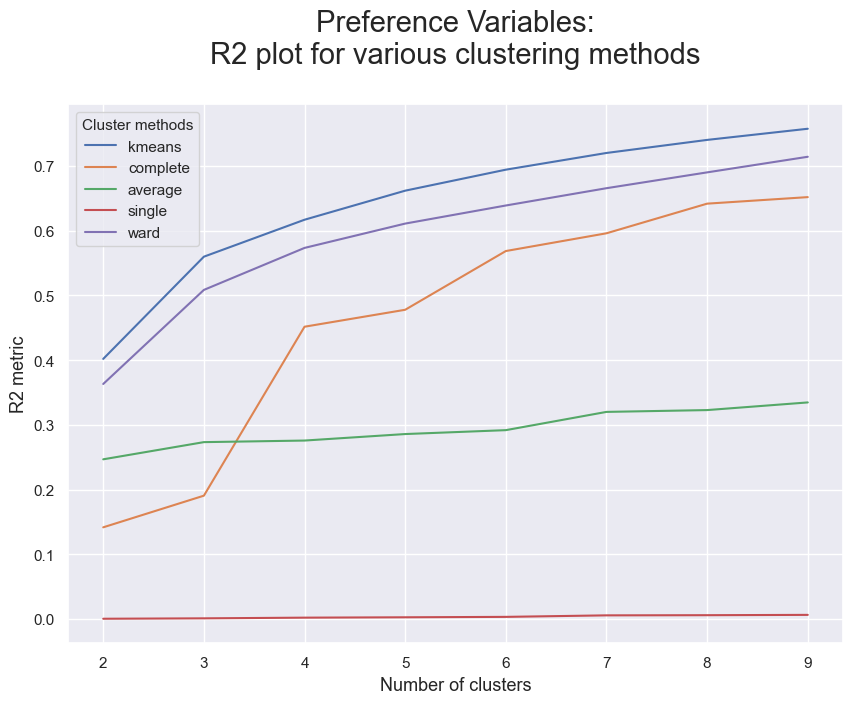

In [24]:
# Obtaining the R² scores for each cluster solution on preference variables
r2_scores_pref = {}
r2_scores_pref['kmeans'] = get_r2_scores(df_prf, preference_features, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores_pref[linkage] = get_r2_scores(
        df_prf, preference_features, hierarchical.set_params(linkage=linkage)
    )

# Visualizing the R² scores for each cluster solution on product variables
pd.DataFrame(r2_scores_pref).plot.line(figsize=(10,7))

plt.title("Preference Variables:\nR2 plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
plt.show()

## **Merging the Perspectives**
- How can we merge different cluster solutions?

In [25]:
# Applying the right clustering (algorithm and number of clusters) for each perspective
kmeans_pref = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=42
)
prod_labels = kmeans_pref.fit_predict(df_prf)

kmeans_behav = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=20,
    random_state=42
)
behavior_labels = kmeans_behav.fit_predict(df_dem)

df['product_labels'] = prod_labels
df['behavior_labels'] = behavior_labels

In [26]:
# Count label frequencies (contigency table)

pd.crosstab(df['behavior_labels'],
            df['product_labels'])

product_labels,0,1,2
behavior_labels,,,
0,640,1330,208
1,1460,1160,1013
2,1231,386,290
3,247,707,43


Any problems here?

- too many clusters
- clusters with few points

<div class="alert alert-block alert-warning" style="font-size:20px;">

- **Clusters with few points:** tipo $(3,2)$ tem apenas $43$ pessoas, se forem pessoas que gastam muito então queremos ficar com este cluster mas se não forem nada demais podemos fazer merge
  - Vamos identificar os seus clusters mais próximos para fazer ***merge***

### **Manual merging: Merge lowest frequency clusters into closest clusters**

<div class="alert alert-block alert-danger" style="font-size:17px">

> No **`groupby`** ela por `[metric_features]` pq ela sabe que **'behavior_labels' + 'product_labels' = 'metric_features'**

In [27]:
# Get centroids of clusters
df_centroids = df.groupby(['behavior_labels', 'product_labels'])\
    [metric_features].mean()

df_centroids

income       frq   clothes   kitchen  \
behavior_labels product_labels                                           
0               0               0.204421 -0.108028 -0.244671 -0.053695   
                1               0.143124 -0.077764  1.052654 -0.575271   
                2               0.224697 -0.236469 -0.860512  1.208364   
1               0              -0.937498 -0.867378 -0.460178 -0.061302   
                1              -0.618162 -0.882446  0.952493 -0.604735   
                2              -1.328229 -0.913881 -1.432161  1.541292   
2               0               1.226037  1.218688 -0.468749 -0.080271   
                1               1.132018  1.211537  0.736300 -0.524088   
                2               1.193349  0.955039 -1.098035  1.199842   
3               0               0.935409  1.306561 -0.206583 -0.048124   
                1               0.693508  1.131881  1.099258 -0.601391   
                2               0.869229  1.025457 -0.717197  1.073944   

                                small_appliances      toys  house_keeping  \
behavior_labels product_labels                                              
0               0                       0.464931  0.012915       0.015716   
                1                      -0.924548 -0.591927      -0.570078   
                2                      -0.261544  1.123394       0.862767   
1               0                       0.912527 -0.049436      -0.013709   
                1                      -0.697857 -0.608306      -0.600578   
                2                       0.021500  1.500632       1.465216   
2               0                       0.950212 -0.030460      -0.051273   
                1                      -0.462424 -0.500623      -0.503053   
                2                       0.248201  1.086981       0.776292   
3               0                       0.457913 -0.040265      -0.048750   
                1                      -0.958321 -0.621980      -0.603579   
                2                      -0.300932  0.792654       0.935015   

                                per_net_purchase  spent_online  
behavior_labels product_labels                                  
0               0                      -0.250625      0.057600  
                1                       0.089591      0.166574  
                2                      -0.361380     -0.073773  
1               0                       0.828193     -0.789332  
                1                       0.653840     -0.761555  
                2                       0.771821     -0.857517  
2               0                      -1.466567      0.288256  
                1                      -1.293445      0.466873  
                2                      -1.428096      0.188365  
3               0                      -0.101336      2.043056  
                1                       0.205066      2.073131  
                2                      -0.187964      1.634177

In [28]:
# Clusters with low frequency to be merged:
# (behavior_label, product_label)
to_merge = [(3,2), (3,0), (2,2), (0,2)]

In [29]:
# Computing the euclidean distance matrix between the centroids
centroid_dists = euclidean = pairwise_distances(df_centroids)

df_dists = pd.DataFrame(
    centroid_dists, 
    columns=df_centroids.index, 
    index=df_centroids.index
)

df_dists

behavior_labels                        0                                 1  \
product_labels                         0         1         2             0   
behavior_labels product_labels                                               
0               0               0.000000  2.174174  2.120592  2.003330e+00   
                1               2.174174  0.000000  3.545347  3.127625e+00   
                2               2.120592  3.545347  0.000000  2.995055e+00   
1               0               2.003330  3.127625  2.995055  2.980232e-08   
                1               2.572955  1.571738  3.812645  2.382104e+00   
                2               3.653265  4.944548  2.406628  3.009913e+00   
2               0               2.151366  3.456696  3.149909  3.932341e+00   
                1               2.536350  2.229857  3.765029  4.320120e+00   
                2               2.755046  4.272795  1.972235  4.273484e+00   
3               0               2.551125  3.233045  3.484767  4.170456e+00   
                1               3.311341  2.328192  4.451981  4.705164e+00   
                2               2.784022  3.794571  2.260489  4.264923e+00   

behavior_labels                                                2            \
product_labels                             1         2         0         1   
behavior_labels product_labels                                               
0               0               2.572955e+00  3.653265  2.151366  2.536350   
                1               1.571738e+00  4.944548  3.456696  2.229857   
                2               3.812645e+00  2.406628  3.149909  3.765029   
1               0               2.382104e+00  3.009913  3.932341  4.320120   
                1               5.960464e-08  4.478048  4.365871  3.588681   
                2               4.478048e+00  0.000000  5.143873  5.802660   
2               0               4.365871e+00  5.143873  0.000000  2.034841   
                1               3.588681e+00  5.802660  2.034841  0.000000   
                2               5.002068e+00  4.087795  2.131452  3.341282   
3               0               4.388363e+00  5.302390  2.312485  2.516758   
                1               3.755586e+00  6.158498  3.646766  2.330816   
                2               4.731248e+00  4.163589  2.867152  3.334879   

behavior_labels                                      3                      
product_labels                             2         0         1         2  
behavior_labels product_labels                                              
0               0               2.755046e+00  2.551125  3.311341  2.784022  
                1               4.272795e+00  3.233045  2.328192  3.794571  
                2               1.972235e+00  3.484767  4.451981  2.260489  
1               0               4.273484e+00  4.170456  4.705164  4.264923  
                1               5.002068e+00  4.388363  3.755586  4.731248  
                2               4.087795e+00  5.302390  6.158498  4.163589  
2               0               2.131452e+00  2.312485  3.646766  2.867152  
                1               3.341282e+00  2.516758  2.330816  3.334879  
                2               5.960464e-08  3.120534  4.566564  2.076673  
3               0               3.120534e+00  0.000000  2.201610  2.003807  
                1               4.566564e+00  2.201610  0.000000  3.360988  
                2               2.076673e+00  2.003807  3.360988  0.000000

<div class="alert alert-block alert-danger" style="font-size:17px">

- O **threshold** é arbitrário!

- para cada $(3,2)$ vê se já tem target então muda a target para a menor dist (sem ser para o próprio cluster **`index=1`**)
    - $(3,2)$ deve ir para o (3,0)
    - $(3,0)$ já é **target** [é o + próximo para e de $(3,2)$ já não vou mudar $(3,0)$]
    - $(2,2)$ vai para $(0,2)$ e $(0,2)$ não vai mudar

</div>

In [30]:
# Merging each low frequency clustering (source) 
# to the closest cluster (target)
source_target = {}

for clus in to_merge:
    # If cluster to merge (source) has not yet been used as target
    if clus not in source_target.values():
        # Add this cluster to source_target map as key
        # Use the cluster with the smallest distance to it as value
        source_target[clus] = df_dists.loc[clus].sort_values().index[1]

source_target

{(3, 2): (3, 0), (2, 2): (0, 2)}

In [31]:
df_ = df.copy()

# Changing the behavior_labels and product_labels based on source_target
for source, target in source_target.items():
    mask = (df_['behavior_labels']==source[0]) & (df_['product_labels']==source[1])
    # para cada (3,2) vou mudar para (3,0)
    # todos os (2,2) vão mudar para (0,2)
    df_.loc[mask, 'behavior_labels'] = target[0]
    df_.loc[mask, 'product_labels'] = target[1]

In [32]:
to_merge

[(3, 2), (3, 0), (2, 2), (0, 2)]

In [33]:
# New contigency table
pd.crosstab(df_['behavior_labels'],
            df_['product_labels'])

product_labels,0,1,2
behavior_labels,,,
0,640,1330,498
1,1460,1160,1013
2,1231,386,0
3,290,707,0


In [34]:
# Original contigency table
pd.crosstab(df['behavior_labels'],
            df['product_labels'])

# (3,0) was target for (3,2), so was not moved
# (0,2) was target for (2,2), so was not moved

product_labels,0,1,2
behavior_labels,,,
0,640,1330,208
1,1460,1160,1013
2,1231,386,290
3,247,707,43


### **Merging using `Hierarchical clustering`**

<div class="alert alert-block alert-warning" style="font-size:17px">

- O problema de fazer com o **`Hierarchical clustering`** é que os clusters com poucas observações podem continuar isolados e pode agrupar clusters que têm muitas observações!

</div>

<div class="alert alert-block alert-danger" style="font-size:17px">

- Podemos fazer isto ou **HClust**.
    - Mas o manual é melhor no sentido em que podemos garante que deixamos de ter o cluster pequeno 

</div>

In [35]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['behavior_labels', 'product_labels'])\
    [metric_features].mean()
df_centroids

income       frq   clothes   kitchen  \
behavior_labels product_labels                                           
0               0               0.204421 -0.108028 -0.244671 -0.053695   
                1               0.143124 -0.077764  1.052654 -0.575271   
                2               0.224697 -0.236469 -0.860512  1.208364   
1               0              -0.937498 -0.867378 -0.460178 -0.061302   
                1              -0.618162 -0.882446  0.952493 -0.604735   
                2              -1.328229 -0.913881 -1.432161  1.541292   
2               0               1.226037  1.218688 -0.468749 -0.080271   
                1               1.132018  1.211537  0.736300 -0.524088   
                2               1.193349  0.955039 -1.098035  1.199842   
3               0               0.935409  1.306561 -0.206583 -0.048124   
                1               0.693508  1.131881  1.099258 -0.601391   
                2               0.869229  1.025457 -0.717197  1.073944   

                                small_appliances      toys  house_keeping  \
behavior_labels product_labels                                              
0               0                       0.464931  0.012915       0.015716   
                1                      -0.924548 -0.591927      -0.570078   
                2                      -0.261544  1.123394       0.862767   
1               0                       0.912527 -0.049436      -0.013709   
                1                      -0.697857 -0.608306      -0.600578   
                2                       0.021500  1.500632       1.465216   
2               0                       0.950212 -0.030460      -0.051273   
                1                      -0.462424 -0.500623      -0.503053   
                2                       0.248201  1.086981       0.776292   
3               0                       0.457913 -0.040265      -0.048750   
                1                      -0.958321 -0.621980      -0.603579   
                2                      -0.300932  0.792654       0.935015   

                                per_net_purchase  spent_online  
behavior_labels product_labels                                  
0               0                      -0.250625      0.057600  
                1                       0.089591      0.166574  
                2                      -0.361380     -0.073773  
1               0                       0.828193     -0.789332  
                1                       0.653840     -0.761555  
                2                       0.771821     -0.857517  
2               0                      -1.466567      0.288256  
                1                      -1.293445      0.466873  
                2                      -1.428096      0.188365  
3               0                      -0.101336      2.043056  
                1                       0.205066      2.073131  
                2                      -0.187964      1.634177

<div class="alert alert-block alert-success" style="font-size:20px;">

- **`metric_features=p1+p2`** **se as perspetivas não tiverem todas as variáveis**

</div>

In [36]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df_centroids)

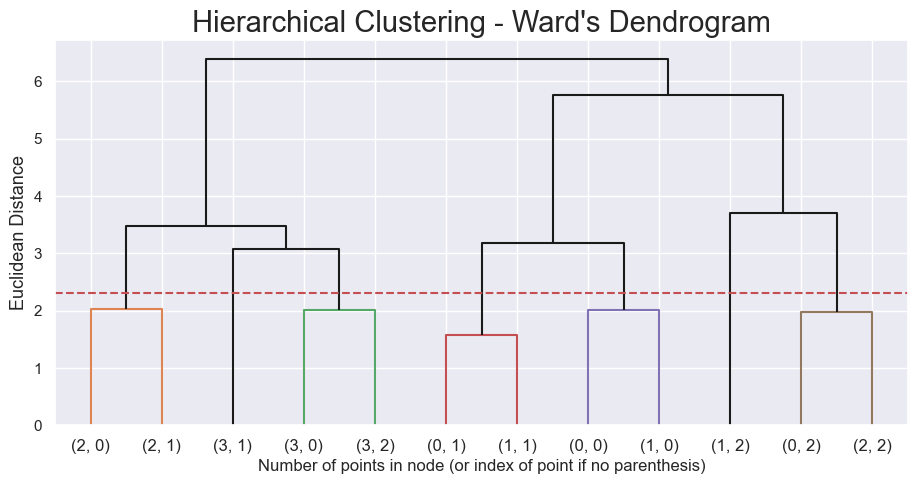

In [37]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# Create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned

y_threshold = 2.3
# y_threshold = 3.3

dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [38]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=7
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

income       frq   clothes   kitchen  \
behavior_labels product_labels                                           
0               0               0.204421 -0.108028 -0.244671 -0.053695   
                1               0.143124 -0.077764  1.052654 -0.575271   
                2               0.224697 -0.236469 -0.860512  1.208364   
1               0              -0.937498 -0.867378 -0.460178 -0.061302   
                1              -0.618162 -0.882446  0.952493 -0.604735   
                2              -1.328229 -0.913881 -1.432161  1.541292   
2               0               1.226037  1.218688 -0.468749 -0.080271   
                1               1.132018  1.211537  0.736300 -0.524088   
                2               1.193349  0.955039 -1.098035  1.199842   
3               0               0.935409  1.306561 -0.206583 -0.048124   
                1               0.693508  1.131881  1.099258 -0.601391   
                2               0.869229  1.025457 -0.717197  1.073944   

                                small_appliances      toys  house_keeping  \
behavior_labels product_labels                                              
0               0                       0.464931  0.012915       0.015716   
                1                      -0.924548 -0.591927      -0.570078   
                2                      -0.261544  1.123394       0.862767   
1               0                       0.912527 -0.049436      -0.013709   
                1                      -0.697857 -0.608306      -0.600578   
                2                       0.021500  1.500632       1.465216   
2               0                       0.950212 -0.030460      -0.051273   
                1                      -0.462424 -0.500623      -0.503053   
                2                       0.248201  1.086981       0.776292   
3               0                       0.457913 -0.040265      -0.048750   
                1                      -0.958321 -0.621980      -0.603579   
                2                      -0.300932  0.792654       0.935015   

                                per_net_purchase  spent_online  hclust_labels  
behavior_labels product_labels                                                 
0               0                      -0.250625      0.057600              2  
                1                       0.089591      0.166574              5  
                2                      -0.361380     -0.073773              4  
1               0                       0.828193     -0.789332              2  
                1                       0.653840     -0.761555              5  
                2                       0.771821     -0.857517              3  
2               0                      -1.466567      0.288256              0  
                1                      -1.293445      0.466873              0  
                2                      -1.428096      0.188365              4  
3               0                      -0.101336      2.043056              1  
                1                       0.205066      2.073131              6  
                2                      -0.187964      1.634177              1

In [39]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()
cluster_mapper


{(0, 0): 2,
 (0, 1): 5,
 (0, 2): 4,
 (1, 0): 2,
 (1, 1): 5,
 (1, 2): 3,
 (2, 0): 0,
 (2, 1): 0,
 (2, 2): 4,
 (3, 0): 1,
 (3, 1): 6,
 (3, 2): 1}

In [40]:
df_ = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['behavior_labels'], row['product_labels'])
    ], axis=1
)

df_ 

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,...,oh_description_Kind of OK,oh_description_Meh...,oh_description_OK nice!,oh_description_Take my money!!,PC0,PC1,PC2,product_labels,behavior_labels,merged_labels
0,78,0.743162,1.191605,0.457819,1402,-0.617023,-0.243065,1.216847,0.495837,-0.499274,...,0.0,0.0,0.0,1.0,0.896356,-1.937697,1.120781,0,2,0
1,88,1.559488,1.100011,-1.535723,1537,0.166160,-0.790228,0.740464,-0.374374,-0.631907,...,0.0,0.0,0.0,1.0,1.981092,-1.421498,0.785625,0,2,0
2,34,-1.548542,-0.823463,0.557496,44,-0.834573,1.672006,-0.371096,-0.809480,2.286023,...,1.0,0.0,0.0,0.0,-2.813108,0.381440,-0.780867,2,1,3
3,69,0.845528,0.550447,-1.402820,888,0.383710,0.440889,-0.768082,-0.084304,-0.234007,...,0.0,0.0,1.0,0.0,1.247013,-0.514177,-1.302203,1,0,5
4,69,0.782435,1.008417,-0.871209,1138,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,...,0.0,0.0,0.0,1.0,1.781920,-0.704805,-0.443376,1,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812,70,0.618993,0.458853,-1.701851,837,0.209670,0.167308,-0.132905,0.205767,-0.764540,...,1.0,0.0,0.0,0.0,1.162525,-0.372854,-0.982963,0,3,1
8813,64,0.874744,0.733635,-1.701851,896,0.731791,-0.243065,-0.609288,-0.519409,-0.366640,...,0.0,0.0,0.0,1.0,2.003026,0.083121,-1.428619,1,3,6
8814,49,-0.455617,-0.731869,-1.535723,61,0.079139,-0.106274,-0.053508,0.060732,-0.101374,...,0.0,1.0,0.0,0.0,-1.002171,1.301747,-0.423851,0,1,2
8815,38,-0.596155,0.825229,0.657173,1011,-0.442982,0.577680,0.581670,-0.809480,0.561792,...,0.0,0.0,0.0,1.0,0.130573,-0.959962,0.332242,0,0,2


In [41]:
# Merged cluster centroids
df_.groupby('merged_labels').mean(numeric_only=True)[metric_features]

,income,frq,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online
merged_labels,,,,,,,,,
0,1.203594,1.216981,-0.181087,-0.186217,0.612996,-0.142695,-0.159119,-1.425240,0.330895
1,0.925596,1.264880,-0.282295,0.118252,0.345395,0.083237,0.097118,-0.114181,1.982429
2,-0.589485,-0.635957,-0.394500,-0.058983,0.776117,-0.030433,-0.004741,0.499410,-0.531220
3,-1.328229,-0.913881,-1.432161,1.541292,0.021500,1.500632,1.465216,0.771821,-0.857517
4,0.788771,0.457381,-0.998829,1.203402,0.035296,1.102190,0.812410,-0.982560,0.078877
5,-0.211531,-0.452636,1.005993,-0.588997,-0.818941,-0.599557,-0.584287,0.352454,-0.265807
6,0.693508,1.131881,1.099258,-0.601391,-0.958321,-0.621980,-0.603579,0.205066,2.073131


<div class="alert alert-block alert-danger" style="font-size:17px">

> Podemos fazer os gráficos para analisar os indivíduos que estão agrupados em cada cluster

</div>

In [42]:
# Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

df_counts

,0
merged_labels,
0,1617
1,290
2,2100
3,1013
4,498
5,2490
6,707


In [43]:
# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts


,merged_labels,0
0,"(2, 1)",1617
1,"(3, 2)",290
2,"(1, 0)",2100
3,"(1, 2)",1013
4,"(2, 2)",498
5,"(1, 1)",2490
6,"(3, 1)",707


In [44]:
df_counts['behavior_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['product_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])

df_counts

,merged_labels,0,behavior_labels,product_labels
0,"(2, 1)",1617,2,1
1,"(3, 2)",290,3,2
2,"(1, 0)",2100,1,0
3,"(1, 2)",1013,1,2
4,"(2, 2)",498,2,2
5,"(1, 1)",2490,1,1
6,"(3, 1)",707,3,1


In [45]:
df_counts.pivot(values=0, index='behavior_labels', columns='product_labels')

product_labels,0,1,2
behavior_labels,,,
1,2100.0,2490.0,1013.0
2,NaN,1617.0,498.0
3,NaN,707.0,290.0


In [46]:
# Setting df to have the final product, behavior and merged clusters
df = df_.copy()

## **Cluster Analysis**

In [1]:
def cluster_profiles(df, label_columns, figsize, 
                     cmap="tab10",
                     compare_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    
    if compare_titles == None:
        compare_titles = [""]*len(label_columns)
        
    fig, axes = plt.subplots(nrows=len(label_columns), 
                             ncols=2, 
                             figsize=figsize, 
                             constrained_layout=True,
                             squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compare_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, 
                                            label, 
                                            color = sns.color_palette(cmap),
                                            ax=ax[0])



        sns.barplot(x=label, 
                    hue=label,
                    y="counts", 
                    data=counts, 
                    ax=ax[1], 
                    palette=sns.color_palette(cmap),
                    legend=False
                    )
        
        # Add % to the barplot
        total = len(df)
        for p in ax[1].patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/total)
            x = p.get_x() + p.get_width() / 2 - 0.05
            y = p.get_y() + p.get_height() + 0.15
            ax[1].annotate(percentage, (x, y), size = 12)
            

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), 
                              rotation=40,
                              ha='right'
                              )
        
        ax[0].legend(handles, cluster_labels,
                     loc='center left', bbox_to_anchor=(1, 0.5), title=label
                     ) # Adaptable to number of clusters
        
        ax[1].set_xticks([i for i in range(len(handles))])
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
        
        
    
    # plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profiling", fontsize=23)
    plt.show()

C:\Users\André Silvestre\AppData\Local\Temp\ipykernel_1756\2074131698.py:35: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(x=label,
C:\Users\André Silvestre\AppData\Local\Temp\ipykernel_1756\2074131698.py:35: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(x=label,
C:\Users\André Silvestre\AppData\Local\Temp\ipykernel_1756\2074131698.py:35: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.barplot(x=label,


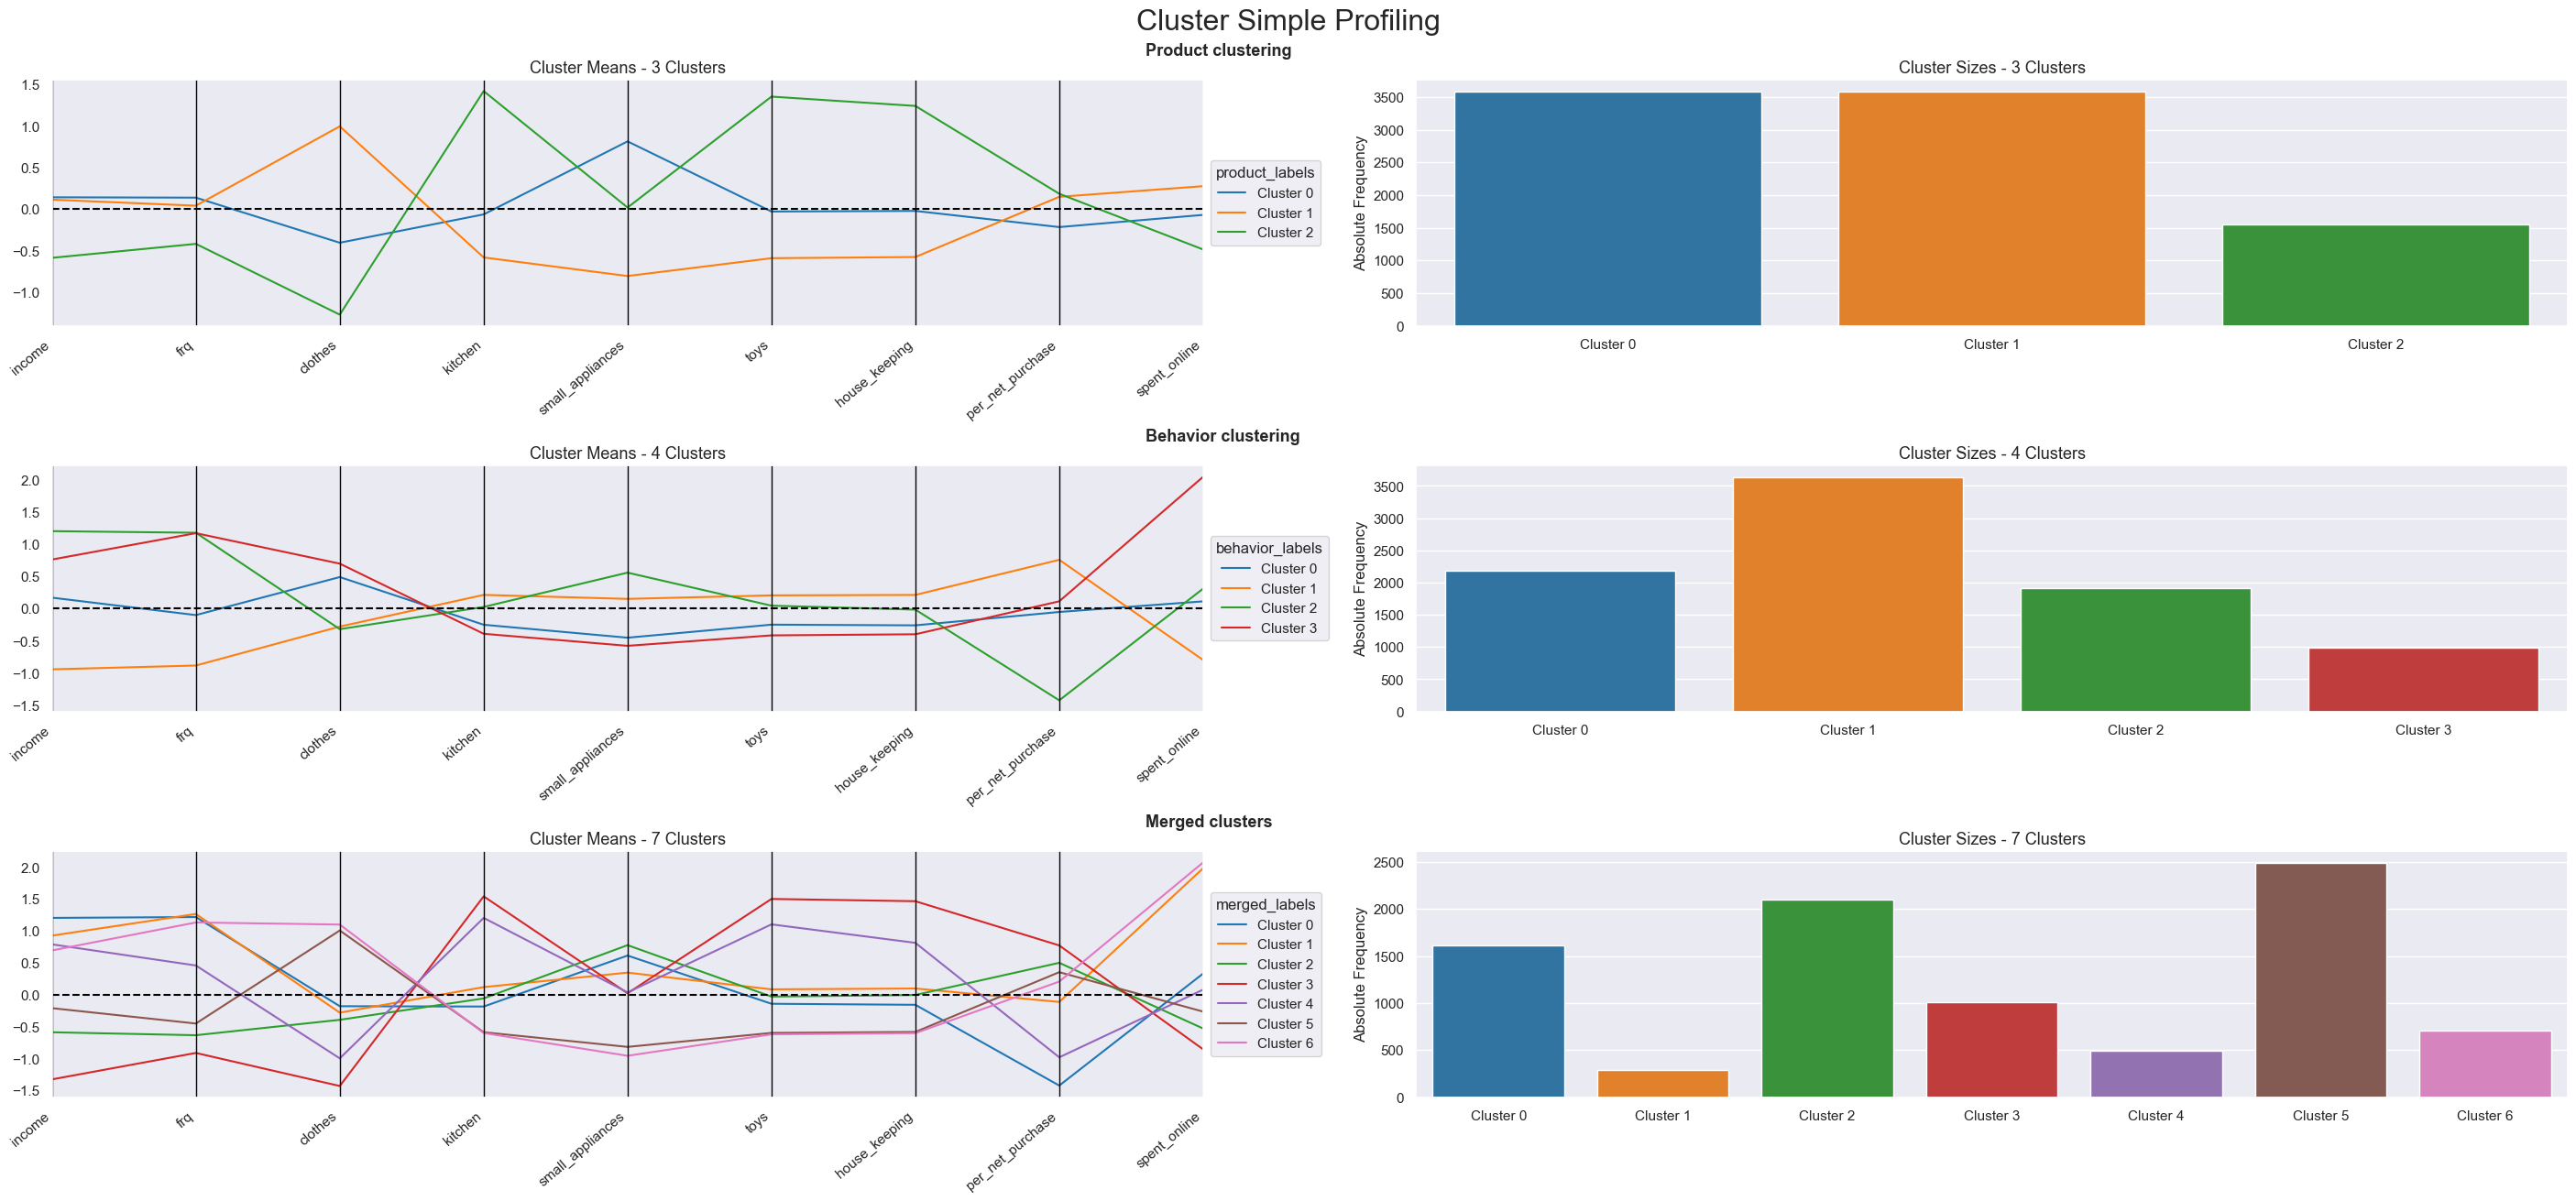

In [48]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df[metric_features + ['product_labels', 'behavior_labels', 'merged_labels', 'SOM+KMeans_labels']], 
    label_columns = ['product_labels', 'behavior_labels', 'merged_labels', 'SOM+KMeans_labels'],
    figsize = (28, 13), 
    compare_titles = ["Product clustering", "Behavior clustering", "Merged clusters", "Overall clustering"]
)

<div class="alert alert-block alert-info" style="font-size:17px">

- Podemos/Devemos tmb analisar as variáveis que **não foram usadas para fazer os clusters**
    - Não usamos para clustering as **var. categóricas**

## **Exercise: Profiling with unused / Categorical features**

In [49]:
non_metric_features

['oh_education_2nd Cycle',
 'oh_education_Graduation',
 'oh_education_Master',
 'oh_education_PhD',
 'oh_status_Married',
 'oh_status_Single',
 'oh_status_Together',
 'oh_status_Widow',
 'oh_gender_M',
 'oh_dependents_1.0',
 'oh_description_Kind of OK',
 'oh_description_Meh...',
 'oh_description_OK nice!',
 'oh_description_Take my money!!']

In [50]:
df_educ = df[['merged_labels',
            'oh_education_2nd Cycle',
            'oh_education_Graduation',
            'oh_education_Master',
            'oh_education_PhD']].groupby(['merged_labels']).sum()

df_educ

,oh_education_2nd Cycle,oh_education_Graduation,oh_education_Master,oh_education_PhD
merged_labels,,,,
0,222.0,868.0,317.0,138.0
1,64.0,150.0,27.0,8.0
2,393.0,1212.0,239.0,94.0
3,224.0,372.0,8.0,1.0
4,180.0,177.0,15.0,4.0
5,254.0,1298.0,556.0,273.0
6,93.0,363.0,140.0,75.0


In [51]:
df[['merged_labels']].groupby(['merged_labels']).value_counts()

merged_labels
0    1617
1     290
2    2100
3    1013
4     498
5    2490
6     707
Name: count, dtype: int64

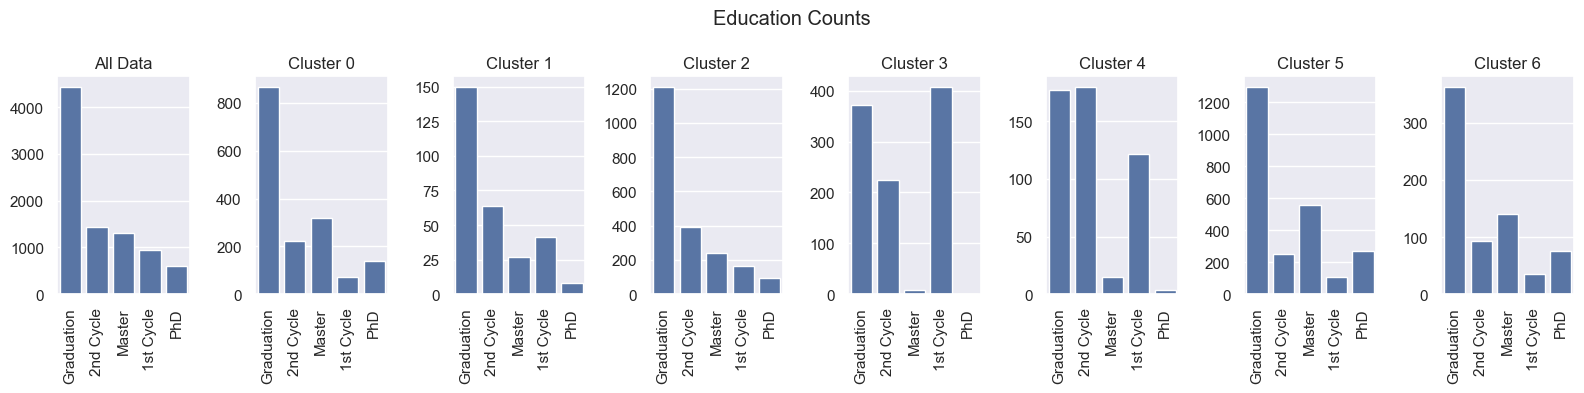

In [52]:
fig, axes = plt.subplots(1, 
                         df['merged_labels'].nunique() + 1, # Add an extra ax for population countplot
                         figsize=(16,4),
                         tight_layout=True,
                        #  sharey=True,
                         )


for i in range(len(axes.flatten())): 
    ax = axes[i]
    if i == 0:
        sns.countplot(df, 
                        x='education', 
                        order = df['education'].value_counts().index,
                        ax=ax)
        ax.set_title("All Data")
        
    else:    
        sns.countplot(df.loc[df['merged_labels']==i-1], 
                    x='education', 
                    order = df['education'].value_counts().index,
                    ax=ax)
        ax.set_title("Cluster {}".format(i-1))
    
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.suptitle("Education Counts", )
plt.show()

<div class="alert alert-block alert-warning" style="font-size:17px">

- Ela comparou o **All Data** com o **Cluster 3** e **Cluster 4**.

In [53]:
merged_counts = df[['merged_labels']].groupby(['merged_labels']).value_counts()
merged_counts


merged_labels
0    1617
1     290
2    2100
3    1013
4     498
5    2490
6     707
Name: count, dtype: int64

<Axes: xlabel='education', ylabel='count'>

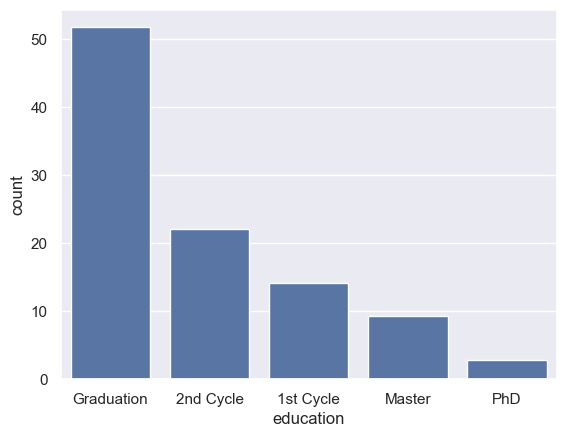

In [54]:
ci = 1
df_ci = df.loc[df['merged_labels']==ci, 'education']

sns.barplot(100*df_ci.value_counts()/merged_counts[ci])


<Axes: xlabel='merged_labels'>

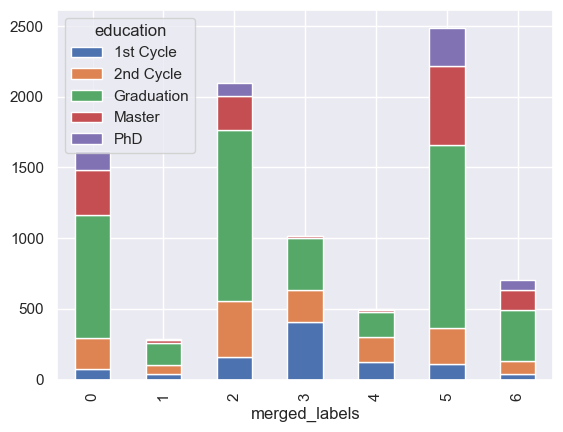

In [55]:
df_cl_ed = df.groupby([
    "merged_labels", 
    "education",
    ])['education'].size().unstack()

df_cl_ed


df_cl_ed.plot.bar(stacked=True)

<Axes: xlabel='merged_labels'>

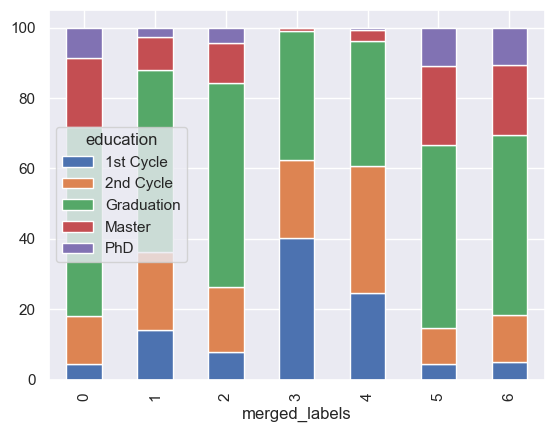

In [56]:
df_cl_ed_pct = df_cl_ed.copy()
for i in df['education'].unique():
    df_cl_ed_pct[i] = 100*df_cl_ed_pct[i]/df['merged_labels'].value_counts().sort_index().values

df_cl_ed_pct.plot.bar(stacked=True)

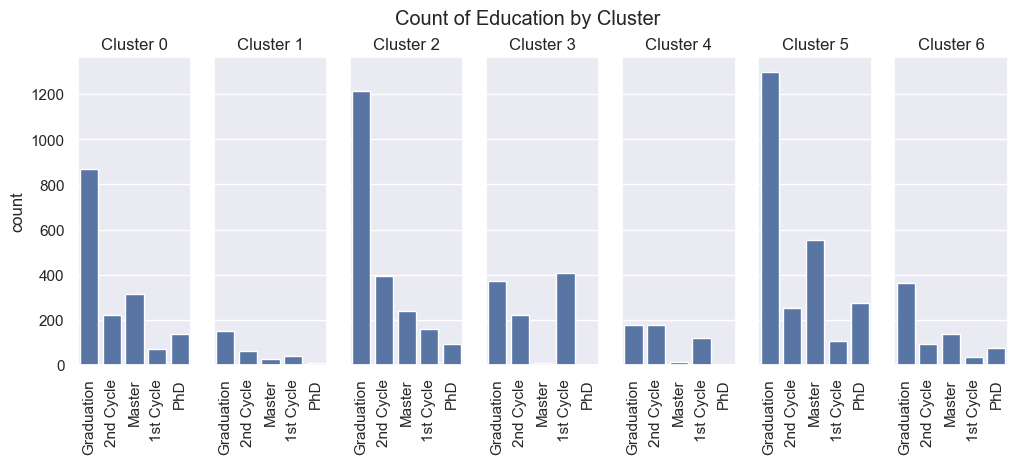

In [57]:
fig, axes = plt.subplots(1, df['merged_labels'].nunique(), 
                         figsize=(12,4),
                         sharey=True,)

for ax, clust in zip(axes.flatten(), range(df['merged_labels'].nunique())): 
    df_cl = df.loc[df['merged_labels']==clust]
    sns.countplot(df_cl, 
                  x='education', 
                  order = df['education'].value_counts().index,
                  ax=ax)
    
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("")

    ax.set_title("Cluster {}".format(clust))
plt.suptitle("Count of Education by Cluster", y=1)
plt.show()

In [58]:
pd.crosstab(df["merged_labels"],df["education"])

education,1st Cycle,2nd Cycle,Graduation,Master,PhD
merged_labels,,,,,
0,72,222,868,317,138
1,41,64,150,27,8
2,162,393,1212,239,94
3,408,224,372,8,1
4,122,180,177,15,4
5,109,254,1298,556,273
6,36,93,363,140,75


### Exercise: What other visualizations from the EDA can you think of?

## Cluster visualization using t-SNE

In [59]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=42).fit_transform(df[metric_features])

<div class="alert alert-block alert-warning" style="font-size:17px">

-  **Ter em atenção a um parâmetro que ela falou**
    - tenta conservar as distâncias, 
- **(não percebi) features usadas para label e não os cluster labels**
    - No meio temos pessoas com vários clusters 
    - O <span style="color:pink">**rosa**</span> e o <span style="color:orange">**laranja**</span> são mesmo parecidos e vamos ver no t-sne que também estão próximo (são outras cores)

</div>

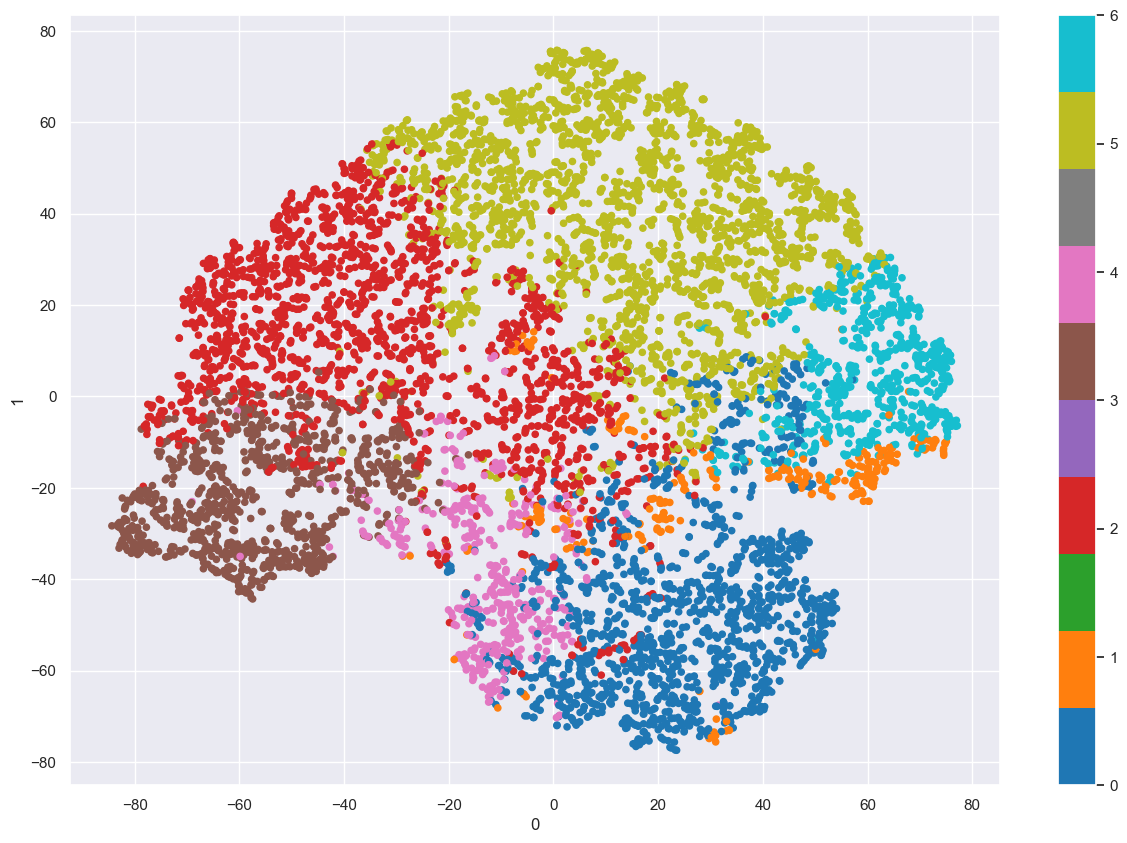

In [60]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()

### Exercise: Improve T-SNE Visualization

### Exercise: Visualize using UMAP

### Exercise: Visualize using Principal Components


## Assess feature importance and reclassify outliers

### Using the R²
What proportion of each variables total SS is explained between clusters?

In [61]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

<div class="alert alert-block alert-warning" style="font-size:17px">

- $R^2$ a variância nos cluster que consegue captar

</div>

In [62]:
# We are essentially decomposing the R² into the R² for each variable
r2_variables(df[metric_features + ['merged_labels']], 'merged_labels').drop('merged_labels')

C:\Users\André Silvestre\AppData\Local\Temp\ipykernel_1756\364241649.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
c:\Anaconda3\envs\DM2425\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


income              0.677211
frq                 0.700756
clothes             0.737270
kitchen             0.516444
small_appliances    0.484307
toys                0.487774
house_keeping       0.468259
per_net_purchase    0.602483
spent_online        0.683473
dtype: float64

### Using a Decision Tree
We get the normalized total reduction of the criterion (gini or entropy) brought by that feature (also known as Gini importance).

In [63]:
# Preparing the data
X = df[metric_features]
y = df.merged_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 79.86% of the customers correctly


<div class="alert alert-block alert-warning" style="font-size:17px">

- $máx$ o 1º split (maior gini)
- features importances
- **Decision Tree** usar para classificar os outliers

</div>

In [64]:
# Assessing feature importance
pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False)

clothes             0.442498
per_net_purchase    0.219365
spent_online        0.205036
frq                 0.098689
kitchen             0.034412
income              0.000000
small_appliances    0.000000
toys                0.000000
house_keeping       0.000000
dtype: float64

In [65]:
# Predicting the cluster labels of the outliers
df_out['merged_labels'] = dt.predict(df_out[metric_features])
df_out.head()

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,...,oh_gender_M,oh_dependents_1.0,oh_description_Kind of OK,oh_description_Meh...,oh_description_OK nice!,oh_description_Take my money!!,PC0,PC1,PC2,merged_labels
15,86,1.550018,2.199138,0.657173,2039,-1.400205,-0.790228,0.502272,1.075978,3.214455,...,1.0,0.0,0.0,0.0,1.0,0.0,0.626497,-3.841512,-0.781766,0
18,77,0.705467,-0.640275,-0.273146,394,-1.704776,-0.379855,-1.165068,3.976684,3.877621,...,1.0,0.0,0.0,1.0,0.0,0.0,-2.708509,-2.873128,-2.400336,0
77,43,-0.409958,0.733635,1.255236,775,-1.226165,-0.653437,1.852024,2.381296,-0.897173,...,1.0,1.0,0.0,0.0,1.0,0.0,-0.498720,-1.294986,0.888224,3
154,28,-1.363078,-1.189839,1.554267,30,-1.791796,1.261634,-1.403260,1.656119,5.071320,...,1.0,1.0,0.0,0.0,1.0,0.0,-4.458206,-1.290910,-2.286064,3
186,70,1.063291,-0.457087,1.521041,338,-1.313185,0.988052,-0.926877,1.221014,3.479722,...,0.0,1.0,1.0,0.0,0.0,0.0,-2.072128,-1.850197,-1.597918,3


In [66]:
# import graphviz

In [67]:
# # Visualizing the decision tree
# dot_data = export_graphviz(dt, out_file=None, 
#                            feature_names=X.columns.to_list(),
#                            filled=True,
#                            rounded=True,
#                            special_characters=True)
# g = graphviz.Source(dot_data)

# g

In [68]:
# from IPython.display import Image

# png_bytes = g.pipe(format='png')
# with open('dt.png','wb') as f:
#     f.write(png_bytes)

# Image(png_bytes)

![Tree](../figures/clustering/dt.png)